<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/Compare_networks_on_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare networks on ImageNet

In this notebook we show how one can use **iNNvestigate** to analyze the prediction of *different* ImageNet-models!

This notebook is an extension of the [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb) notebook.


## Imports

Innvestigate Toolbox is installed. The toolbox contains multiple visualization methods being used in this experiment.
Also some needed helper files are clone from the understanding_cnn repository. The whole folder is removed, after moving all needed helpers to the /content/ directory

In [1]:
!pip install -q git+https://github.com/albermax/innvestigate
!pip install -q deeplift
!git clone https://github.com/infomon/understanding_cnn
  
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_imagenet.py"):
  shutil.move("/content/understanding_cnn/utils/utils_imagenet.py", "/content")
if not os.path.isdir("models"):
  shutil.move("/content/understanding_cnn/models", "/content")
if not os.path.isdir("images"):
  shutil.move("/content/understanding_cnn/data/images", "/content")
if not os.path.isfile("data_loader.py"):
  shutil.move("/content/understanding_cnn/data/data_loader.py", "/content")
  
!rm -r understanding_cnn

!pip install scipy==1.2.0

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 108 (delta 39), reused 71 (delta 15), pack-reused 0
Receiving objects: 100% (108/108), 14.85 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

import models.model_loader as model_loader
import data_loader

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
imgnetutils = imp.load_source("utils_imagenet", "utils_imagenet.py")

# We create many graphs, let's not run out of memory.
if keras.backend.backend() == "tensorflow":
    config = keras.backend.tf.ConfigProto()
    config.gpu_options.allow_growth = True
    keras.backend.set_session(keras.backend.tf.Session(config=config))

Using TensorFlow backend.
W0320 11:05:35.554983 139707026507648 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Models, data and analyzers

We choose a set of ImageNet models:

In [0]:
# Choose a list of models
netnames = [
    # NAME                  MODEL LOADER
    #["AlexNet",             model_loader.AlexNet],
    ["VGG19",               model_loader.VGG19],
    ["Inception_v3",        model_loader.Inception_v3],
    ["Inception_Resnet_v2", model_loader.Inception_Resnet_v2],
    ["Resnet_v2_152",       model_loader.Resnet_v2_152],
    ["ResNeXt_101",         model_loader.Resnet_v1_101]
]          
n_nets = len(netnames)

The following function will load a specific model, load the data in the respective format and create analyzers for this model.

**For a better understanding of this part we refer to the [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb) notebook, from which this code segment is adopted from.**

In [0]:
def prepare_model_data_and_analyzers(loader):
    # Load the model definition.
    model = loader()

    # Get some example test set images.
    data = data_loader.load_from_folder("images",model.get_image_size())

    
    images = [] 
    label_to_class_name = []
    for img,label in data:
      images.append(img)
      label_to_class_name.append(label)
      
    
    patterns = model.get_patterns()
    input_range = (-1,1)

    noise_scale = (input_range[1]-input_range[0]) * 0.1

    # Methods we use and some properties.
    methods = [
        # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
        # Show input.
        ("input",                 {},                       imgnetutils.image,         "Input"), #0

        # Function
        ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"), #1
        ("smoothgrad",            {"augment_by_n": 16,
                                   "noise_scale": noise_scale,
                                   "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"), #2

        # Signal
        ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"), #3
        ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",), #4
        ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"), #5

        # Interaction
        ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"), #6
        ("deep_taylor.bounded",   {"low": input_range[0],
                                   "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"), #7
        ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"), #8
        ("integrated_gradients",  {"reference_inputs": input_range[0],
                                   "steps": 16},            imgnetutils.heatmap,       "Integrated Gradients"), #9
        ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,        "LRP-Epsilon"), #10
        ("lrp.epsilon_IB",           {"epsilon": 1},           imgnetutils.heatmap,        "LRP-Epsilon IB"), #11
        ("lrp.alpha_1_beta_0",           {},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0"), #12
        ("lrp.alpha_1_beta_0_IB",           {},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0 IB"), #13
        ("lrp.alpha_2_beta_1",           {},           imgnetutils.heatmap,        "LRP-Alpha2-Beta1"), #14
        ("lrp.alpha_2_beta_1_IB",           {},           imgnetutils.heatmap,        "LRP-Alpha2-Beta1 IB"), #15
        ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"), #16 
        ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"), #17
    ]
    
    # Select methods of your choice
    selected_methods_indices = [0,1,11,13,15]
    selected_methods = [methods[i] for i in selected_methods_indices]
    print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))
    
    # Create model without trailing softmax
    model_wo_softmax = model.get_model()

    # Create analyzers.
    analyzers = []
    for method in selected_methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax, # model without softmax output
                                                    **method[1])      # optional analysis parameters
        except innvestigate.NotAnalyzeableModelException:
            # Not all methods work with all models.
            analyzer = None
            print(method[3]+" cannot be used!")
        analyzers.append(analyzer)
        
    return (images, label_to_class_name,
            selected_methods, model, model_wo_softmax, analyzers)

## Analysis

Now we analyze each image with the different networks and different analyzers:

In [6]:
analyses = {}
texts = {}
    
for (netname,loader) in netnames:
    print("Creating analyses for network {}.".format(netname))
    tmp = prepare_model_data_and_analyzers(loader)
    (images, label_to_class_name,
     methods, model, model_wo_softmax, analyzers) = tmp
    
    analysis = np.zeros([len(images), len(analyzers)]+list(model.get_image_size())+[3])
    text = []
    
    channels_first = keras.backend.image_data_format() == "channels_first"
    color_conversion = "BGRtoRGB" if model.get_color_coding() == "BGR" else None

    for i, x in enumerate(images):
        # Add batch axis.
        x_pp = model.preprocess_input(x)

        # Predict final activations, probabilites, and label.
        presm = model.predict_wo_softmax(x_pp)[0]
        prob = model.predict_with_softmax(x_pp)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[i],    # ground truth label
                     "%.2f" % presm.max(),             # pre-softmax logits
                     "%.2f" % prob.max(),              # probabilistic softmax output  
                     "%s" % model.decode_predictions(prob[None,...], top=1)[0][1] # predicted label
                    ))

        for aidx, analyzer in enumerate(analyzers):
            print(methods[aidx][0]+" for image with label "+label_to_class_name[i])
            if methods[aidx][0] == "input":
                # Do not analyze, but keep not preprocessed input.
                a = x / 255
            elif analyzer:
                # Analyze.
                a = analyzer.analyze(x_pp)

                # Apply common postprocessing, e.g., re-ordering the channels for plotting.
                a = imgnetutils.postprocess(a, color_conversion, channels_first)
                # Apply analysis postprocessing, e.g., creating a heatmap.
                a = methods[aidx][2](a)
            else:
                a = np.zeros_like(x)
            # Store the analysis.
            analysis[i, aidx] = a[0]

        analyses[netname] = analysis
        texts[netname] = text

Creating analyses for network VGG19.
Instructions for updating:
Colocations handled automatically by placer.


W0320 11:05:37.438326 139707026507648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


574619648/574614434 [==============================] - 19s 0us/step
Using method(s) "['input', 'gradient', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0_IB', 'lrp.alpha_2_beta_1_IB']".
40960/35363 [==================================] - 0s 2us/step
input for image with label dog
gradient for image with label dog
Instructions for updating:
Use tf.cast instead.


W0320 11:06:26.992149 139707026507648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0320 11:06:27.022346 139707026507648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


lrp.epsilon_IB for image with label dog
lrp.alpha_1_beta_0_IB for image with label dog
lrp.alpha_2_beta_1_IB for image with label dog
input for image with label bell pepper
gradient for image with label bell pepper
lrp.epsilon_IB for image with label bell pepper
lrp.alpha_1_beta_0_IB for image with label bell pepper
lrp.alpha_2_beta_1_IB for image with label bell pepper
input for image with label airplane
gradient for image with label airplane
lrp.epsilon_IB for image with label airplane
lrp.alpha_1_beta_0_IB for image with label airplane
lrp.alpha_2_beta_1_IB for image with label airplane
input for image with label leopard
gradient for image with label leopard
lrp.epsilon_IB for image with label leopard
lrp.alpha_1_beta_0_IB for image with label leopard
lrp.alpha_2_beta_1_IB for image with label leopard
input for image with label husky
gradient for image with label husky
lrp.epsilon_IB for image with label husky
lrp.alpha_1_beta_0_IB for image with label husky
lrp.alpha_2_beta_1_IB fo

I0320 11:06:55.955412 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0320 11:07:04.010569 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_172 (Lambda)          (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Using method(s) "['input', 'gradient', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0_IB', 'lrp.alpha_2_beta_1_IB']".
Input cannot be used!
Gradient cannot be used!
LRP-Epsilon cannot be used!
LRP-Alpha1-Beta0 IB cannot be used!
LRP-Alpha2-Beta1 IB cannot be used!
16384/10484 [==============================================] - 0s 0us/step
input for image with label dog
gradient for image with label dog
lrp.epsilon_IB for image with label dog
lrp.alpha_1_beta_0_IB for image with label dog
lrp.alpha_2_beta_1_IB for image with label dog
input for image with label bell pepper
gradient for image with label bell pepper
lrp.epsilon_IB for image with label bell pepper
lrp.alpha_1_beta_

I0320 11:08:06.990111 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0320 11:08:33.189348 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_173 (Lambda)          (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Using method(s) "['input', 'gradient', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0_IB', 'lrp.alpha_2_beta_1_IB']".
Input cannot be used!
Gradient cannot be used!
LRP-Epsilon cannot be used!
LRP-Alpha1-Beta0 IB cannot be used!
LRP-Alpha2-Beta1 IB cannot be used!
input for image with label dog
gradient for image with label dog
lrp.epsilon_IB for image with label dog
lrp.alpha_1_beta_0_IB for image with label dog
lrp.alpha_2_beta_1_IB for image with label dog
input for image with label bell pepper
gradient for image with label bell pepper
lrp.epsilon_IB for image with label bell pepper
lrp.alpha_1_beta_0_IB for image with label bell pepper
lrp.alpha_2_beta_1_IB for image with 

I0320 11:11:19.143194 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0320 11:11:51.337435 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_174 (Lambda)          (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Using method(s) "['input', 'gradient', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0_IB', 'lrp.alpha_2_beta_1_IB']".
Input cannot be used!
Gradient cannot be used!
LRP-Epsilon cannot be used!
LRP-Alpha1-Beta0 IB cannot be used!
LRP-Alpha2-Beta1 IB cannot be used!
input for image with label dog
gradient for image with label dog
lrp.epsilon_IB for image with label dog
lrp.alpha_1_beta_0_IB for image with label dog
lrp.alpha_2_beta_1_IB for image with label dog
input for image with label bell pepper
gradient for image with label bell pepper
lrp.epsilon_IB for image with label bell pepper
lrp.alpha_1_beta_0_IB for image with label bell pepper
lrp.alpha_2_beta_1_IB for image with 

I0320 11:16:45.196617 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0320 11:17:29.638795 139707026507648 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_175 (Lambda)          (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Using method(s) "['input', 'gradient', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0_IB', 'lrp.alpha_2_beta_1_IB']".
Input cannot be used!
Gradient cannot be used!
LRP-Epsilon cannot be used!
LRP-Alpha1-Beta0 IB cannot be used!
LRP-Alpha2-Beta1 IB cannot be used!
input for image with label dog
gradient for image with label dog
lrp.epsilon_IB for image with label dog
lrp.alpha_1_beta_0_IB for image with label dog
lrp.alpha_2_beta_1_IB for image with label dog
input for image with label bell pepper
gradient for image with label bell pepper
lrp.epsilon_IB for image with label bell pepper
lrp.alpha_1_beta_0_IB for image with label bell pepper
lrp.alpha_2_beta_1_IB for image with 

Next, we visualize the analysis results:

10
Image nr. 0, true label: dog


<Figure size 432x288 with 0 Axes>

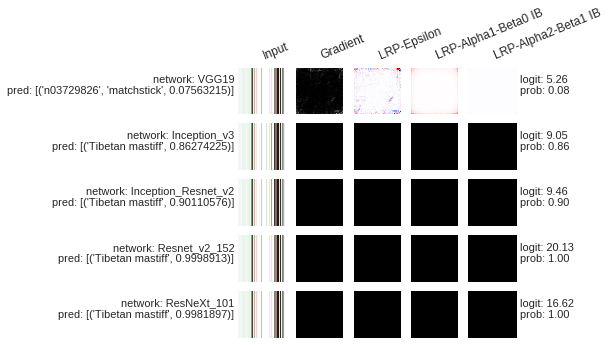

Image nr. 1, true label: bell pepper


<Figure size 432x288 with 0 Axes>

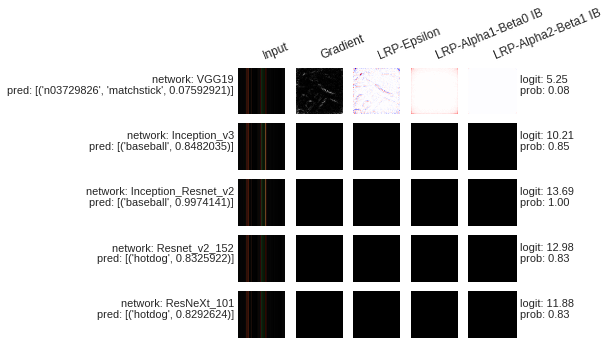

Image nr. 2, true label: airplane


<Figure size 432x288 with 0 Axes>

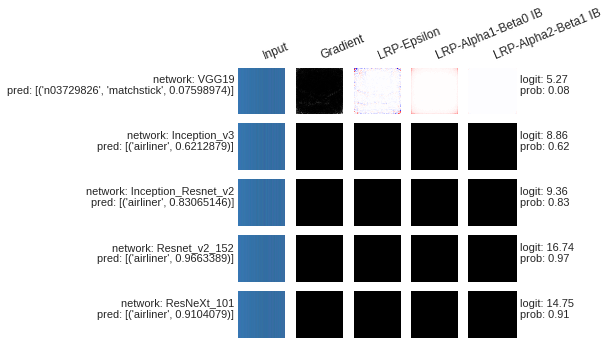

Image nr. 3, true label: leopard


<Figure size 432x288 with 0 Axes>

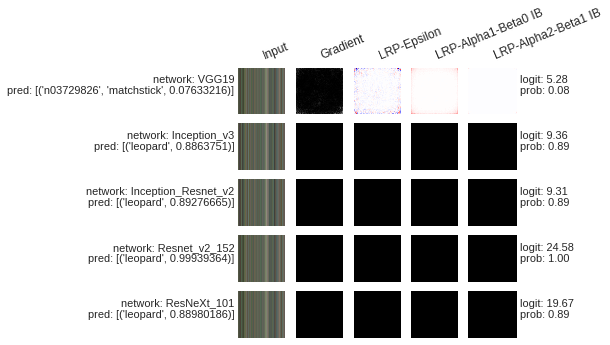

Image nr. 4, true label: husky


<Figure size 432x288 with 0 Axes>

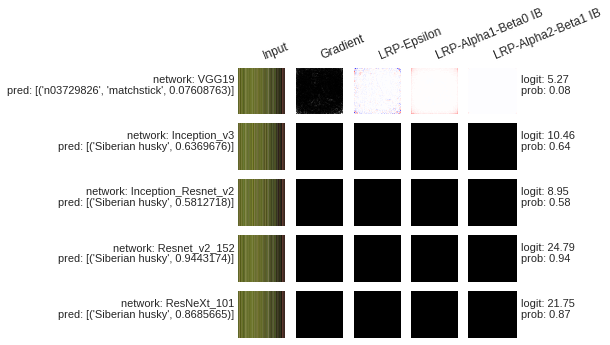

Image nr. 5, true label: tabby_cat


<Figure size 432x288 with 0 Axes>

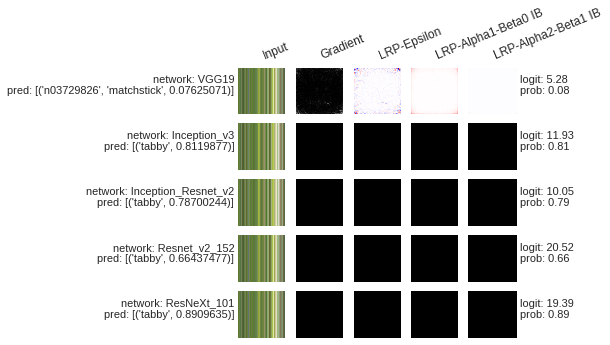

Image nr. 6, true label: gruffed grouse


<Figure size 432x288 with 0 Axes>

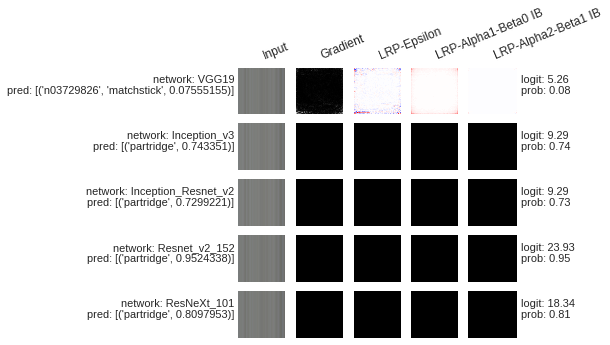

Image nr. 7, true label: accordion


<Figure size 432x288 with 0 Axes>

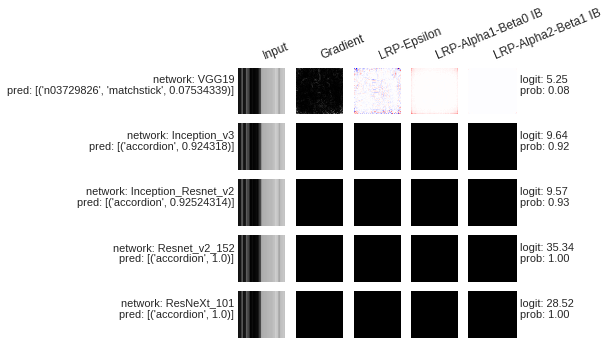

Image nr. 8, true label: african elephant


<Figure size 432x288 with 0 Axes>

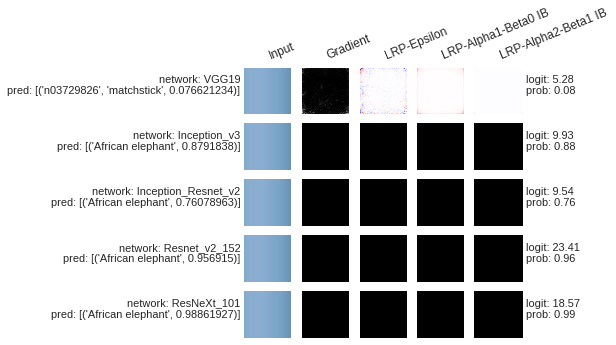

Image nr. 9, true label: subway train


<Figure size 432x288 with 0 Axes>

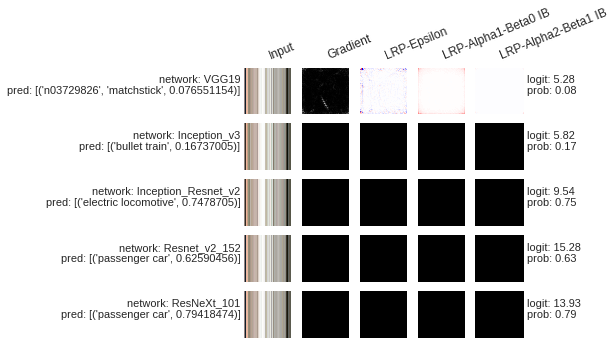

In [12]:
n_images = analyses[netnames[0][0]].shape[0]

# Prepare common labels
col_labels = [''.join(method[3]) for method in methods]

for image_index in range(n_images):
    grid = []
    row_labels_left = []
    row_labels_right = []
    
    for netname,_ in netnames:
        analysis, text = analyses[netname], texts[netname]
        # Prepare the grid as rectengular list
        grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
        # Prepare the labels
        label, presm, prob, pred = zip(*text)
        label = label[image_index]
        row_labels_left.append(('network: {}'.format(netname),'pred: {}'.format(pred[image_index])))
        row_labels_right.append(('logit: {}'.format(presm[image_index]),'prob: {}'.format(prob[image_index])))

    # Plot the analysis.
    print("Image nr. {}, true label: {}".format(image_index, label))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                           file_name=os.environ.get("plot_file_name", None))

This figures show the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).